# Introduction
Hedging is a key financial strategy used to minimize the risk of adverse price movements in assets by taking opposite positions in related assets. Its origins date back to ancient times, and today it involves using advanced financial instruments like options, futures, forwards, and swaps to lock in prices and protect against volatility. This project explores delta hedging techniques, their applications in financial markets, and the trade-offs involved in implementing such strategies. 

This project focuses on the application of call option hedging using the underlying stocks against market risks. It aims to examine the impact of hedging strategies on portfolio performance over time, evaluating their effectiveness in mitigating potential financial losses. Particular emphasis will be placed on delta hedging, a technique that involves adjusting hedge positions based on the sensitivity of an option’s price to fluctuations in the underlying asset. Through this analysis, the project aims to provide comprehensive insights into the practical implementation and advantages of these hedging strategies within financial markets. 

## Types of Hedging 
**Static Hedging**

Static hedging is a risk management strategy where a hedge position is set up once and maintained without adjustments over time. Unlike dynamic hedging, which requires continuous rebalancing, static hedging involves using financial instruments like options or futures to lock in a specific risk exposure. Its advantages include simplicity and lower transaction costs, as no frequent changes are needed. However, it has limitations, such as reduced flexibility and potential ineffectiveness if market conditions change, leaving the investor exposed to unforeseen risks. Static hedging is best suited for stable market conditions or when dynamic hedging is too costly or complex. 

**Dynamic Hedging**
 
Dynamic hedging is a strategy where hedge positions are continuously adjusted in response to changes in the price of the underlying asset. Unlike static hedging, it requires frequent rebalancing to maintain a desired risk level. This approach offers effective risk management, flexibility, and precise control over market exposure. However, it can incur higher costs due to frequent transactions and requires advanced expertise and resources to manage effectively. Dynamic hedging is best suited for volatile markets or situations where risk exposure changes frequently. 

This project will focus on **dynamic hedging**

In [654]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from scipy.stats import norm


In [655]:
Options_data = pd.read_csv("Options Data.csv")

In [656]:
# Data cleaning

## Data Exploration and Preprocessing

The dataset contains detailed information on option prices for contracts listed on the Chicago Board Options Exchange (CBOE) for the S&P 500 Index. The data includes various variables related to option pricing, volatility, and the Greeks (Delta, Gamma), along with trade volume and option style. All options in this dataset are European-style options, as indicated by the "E" in the last column. The following is the meta data for each variable, which will be considered in the simulation: 

In [657]:
print(Options_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 17 columns):
 #   Column                                    Non-Null Count    Dtype  
---  ------                                    --------------    -----  
 0   Security ID                               1048575 non-null  int64  
 1   The Date of this Price                    1048575 non-null  int64  
 2   Option Symbol                             1048575 non-null  object 
 3   Expiration Date of the Option             1048575 non-null  int64  
 4   C=Call, P=Put                             1048575 non-null  object 
 5   Strike Price of the Option Times 1000     1048575 non-null  int64  
 6   Highest Closing Bid Across All Exchanges  1048575 non-null  float64
 7   Lowest  Closing Ask Across All Exchanges  1048575 non-null  float64
 8   Volume                                    1048575 non-null  int64  
 9   Implied Volatility of the Option          927859 non-null   float64
 10  Delta 

## Data Wrangling 
Several data cleaning steps were carried out to ensure proper handling of the variables in the dataset. Initially, the dataset was loaded into Jupyter Notebook, and the columns were renamed for improved readability and easier manipulation during analysis. This step ensured that each variable had a meaningful and accessible name, streamlining the workflow for subsequent data analysis and modelling tasks. 

The first task involved removing null values from the dataset to preserve data integrity. Next, attention was given to the date columns, which were converted to the appropriate datetime format. This transformation ensured that the dates were correctly recognized, enabling accurate time-based analysis, such as sorting, filtering, and time series analysis.  

Following the handling of missing data, several key columns were added to enhance the dataset. These included Time to Expiry, Risk-Free Rate, and Underlying Stock Price. 

 Time to Expiry was calculated by finding the difference between the Expiration Date and the Date at this Price, providing an accurate measure of the remaining life of each option, which is essential for option pricing models. 

 For the Risk-Free Rate, data for 2012 and 2013 were available in various forms, such as 4-week Bank Discount, 4-week Coupon Equivalent, 13-week Bank Discount, and 13-week Coupon Equivalent. Given that we were interested in the rates that reflect the annualized yield on government securities, the Coupon Equivalent rate was chosen. This rate is most suitable for discounting future cash flows, as it reflects the annual yield and is the standard yield measure for U.S. Treasury bills. 

 The interest rate data was then merged with the options dataset based on dates, ensuring the correct coupon equivalent rates were aligned with the respective time to expiry for each option. 

 Additionally, the corresponding stock dataset was obtained from Yahoo Finance, which provided the necessary data for the Underlying Stock Price. This dataset was merged with the options dataset based on the dates, ensuring that each option’s data was paired with the correct stock price on the respective trading date. By merging the two datasets, the Underlying Stock Price for each option was accurately aligned with the respective option data, providing a comprehensive view of the option's behaviour relative to the stock's movements. This step was critical for building accurate models and analysing the relationship between the options and the underlying asset. 

 Once the Underlying Stock Price, Risk-Free Rate, and Time to Expiry were obtained and Delta was available, the European call option price was calculated using the average from the high and low bid price. 

In [658]:
# Renaming columns for easier access 
Options_data.columns = (
    Options_data.columns.str.replace(' ', '_')  # Replace spaces with underscores
                .str.replace(r'[^\w]', '', regex=True))

Options_data.rename(columns={
    "The_Date_of_this_Price": "Date_of_this_Price",
    "Expiration_Date_of_the_Option": "Option_Expiration_Date"
}, inplace=True)


In [659]:
Options_data.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 17 columns):
 #   Column                                    Non-Null Count    Dtype  
---  ------                                    --------------    -----  
 0   Security_ID                               1048575 non-null  int64  
 1   Date_of_this_Price                        1048575 non-null  int64  
 2   Option_Symbol                             1048575 non-null  object 
 3   Option_Expiration_Date                    1048575 non-null  int64  
 4   CCall_PPut                                1048575 non-null  object 
 5   Strike_Price_of_the_Option_Times_1000     1048575 non-null  int64  
 6   Highest_Closing_Bid_Across_All_Exchanges  1048575 non-null  float64
 7   Lowest__Closing_Ask_Across_All_Exchanges  1048575 non-null  float64
 8   Volume                                    1048575 non-null  int64  
 9   Implied_Volatility_of_the_Option          927859 non-null   float64
 10  Delta_

In [660]:
# Keeping only relevant columns to this exersize 
Options_data["Date_of_this_Price"] = Options_data["Date_of_this_Price"].astype(str)
Options_data["Option_Expiration_Date"] = Options_data["Option_Expiration_Date"].astype(str)
Options_data['Date_of_this_Price'] = pd.to_datetime(Options_data['Date_of_this_Price'],format='%Y%m%d')
Options_data['Option_Expiration_Date'] = pd.to_datetime(Options_data['Option_Expiration_Date'],format='%Y%m%d')

# Dropping NA values 
Options_data.dropna(inplace=True) 

# Understanding Data
print(Options_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 927859 entries, 1 to 1048574
Data columns (total 17 columns):
 #   Column                                    Non-Null Count   Dtype         
---  ------                                    --------------   -----         
 0   Security_ID                               927859 non-null  int64         
 1   Date_of_this_Price                        927859 non-null  datetime64[ns]
 2   Option_Symbol                             927859 non-null  object        
 3   Option_Expiration_Date                    927859 non-null  datetime64[ns]
 4   CCall_PPut                                927859 non-null  object        
 5   Strike_Price_of_the_Option_Times_1000     927859 non-null  int64         
 6   Highest_Closing_Bid_Across_All_Exchanges  927859 non-null  float64       
 7   Lowest__Closing_Ask_Across_All_Exchanges  927859 non-null  float64       
 8   Volume                                    927859 non-null  int64         
 9   Implied_Volatility_

In [661]:
Options_data[Options_data["Volume"]>0]

,Security_ID,Date_of_this_Price,Option_Symbol,Option_Expiration_Date,CCall_PPut,Strike_Price_of_the_Option_Times_1000,Highest_Closing_Bid_Across_All_Exchanges,Lowest__Closing_Ask_Across_All_Exchanges,Volume,Implied_Volatility_of_the_Option,Delta_of_the_Option,Gamma_of_the_Option,VegaKappa_of_the_Option,Unique_ID_for_the_Option_Contract,Index_Flag,Description_of_the_Issuing_Company,American_European_or_
29,108105,2012-09-04,SPX 120922C1140000,2012-09-22,C,1140000,262.7,265.70,25,0.462471,0.984881,0.000263,10.511190,81954858,1,CBOE S&P 500 INDEX,E
31,108105,2012-09-04,SPX 120922C1150000,2012-09-22,C,1150000,252.7,255.80,25,0.449924,0.983615,0.000291,11.322800,65475422,1,CBOE S&P 500 INDEX,E
41,108105,2012-09-04,SPX 120922C1200000,2012-09-22,C,1200000,202.9,206.10,1,0.382302,0.976037,0.000482,15.948040,65498725,1,CBOE S&P 500 INDEX,E
57,108105,2012-09-04,SPX 120922C1280000,2012-09-22,C,1280000,123.8,127.60,1,0.286818,0.940090,0.001390,34.488380,81689885,1,CBOE S&P 500 INDEX,E
63,108105,2012-09-04,SPX 120922C1310000,2012-09-22,C,1310000,94.4,98.40,239,0.244981,0.913687,0.002163,45.848050,81951186,1,CBOE S&P 500 INDEX,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048566,108105,2013-12-26,SPXW 131227C1920000,2013-12-27,C,1920000,0.0,0.05,6,0.287792,0.002997,0.000329,0.881278,102173728,1,CBOE S&P 500 INDEX,E
1048567,108105,2013-12-26,SPXW 131227C1925000,2013-12-27,C,1925000,0.0,0.05,200,0.303966,0.002850,0.000298,0.842310,102173729,1,CBOE S&P 500 INDEX,E
1048568,108105,2013-12-26,SPXW 131227C1930000,2013-12-27,C,1930000,0.0,0.05,81,0.320018,0.002719,0.000271,0.807164,102173730,1,CBOE S&P 500 INDEX,E
1048569,108105,2013-12-26,SPXW 131227C1950000,2013-12-27,C,1950000,0.0,0.05,2,0.383113,0.002304,0.000195,0.695102,102173731,1,CBOE S&P 500 INDEX,E


In [662]:
# Filtering for a singular call option
Options_data = Options_data[Options_data["Option_Symbol"]=="SPX 120922C1310000"].head(1)
Options_data

,Security_ID,Date_of_this_Price,Option_Symbol,Option_Expiration_Date,CCall_PPut,Strike_Price_of_the_Option_Times_1000,Highest_Closing_Bid_Across_All_Exchanges,Lowest__Closing_Ask_Across_All_Exchanges,Volume,Implied_Volatility_of_the_Option,Delta_of_the_Option,Gamma_of_the_Option,VegaKappa_of_the_Option,Unique_ID_for_the_Option_Contract,Index_Flag,Description_of_the_Issuing_Company,American_European_or_
63,108105,2012-09-04,SPX 120922C1310000,2012-09-22,C,1310000,94.4,98.4,239,0.244981,0.913687,0.002163,45.84805,81951186,1,CBOE S&P 500 INDEX,E


In [663]:
# Setting the option price as we arent given actual option price
Options_data['Option_Price'] = (Options_data['Highest_Closing_Bid_Across_All_Exchanges'] + Options_data['Lowest__Closing_Ask_Across_All_Exchanges']) / 2

In [664]:
# This functions creates a column for each day between the date of the sale and the expiration date
expanded_rows = []
for _, row in Options_data.iterrows():
    current_date = row["Date_of_this_Price"]
    expiration_date = row["Option_Expiration_Date"]
    
    # Loop day by day and add rows
    while current_date <= expiration_date:
        new_row = row.copy()
        new_row["Date_of_this_Price"] = current_date
        expanded_rows.append(new_row)
        current_date += pd.Timedelta(days=1)  # Move to the next day

# Create expanded DataFrame
Options_data = pd.DataFrame(expanded_rows)

In [665]:
# Creating variable T as the number of days as T must be in years for the black scholes model
Options_data['T'] = ((Options_data['Option_Expiration_Date'] - Options_data['Date_of_this_Price']).dt.days)
Options_data['Option_Strike_Price'] = (Options_data['Strike_Price_of_the_Option_Times_1000']/1000)

In [666]:
# Calculated the intrest rate based on the expiration date 
Interest_rate_2012 = pd.read_csv("daily-treasury-rates-6.csv")
Interest_rate_2013 = pd.read_csv("daily-treasury-rates-4.csv")
Interest_rate_2012["Date"] = pd.to_datetime(Interest_rate_2012['Date'], format='%m/%d/%Y')
Interest_rate_2013["Date"] = pd.to_datetime(Interest_rate_2013['Date'], format='%m/%d/%Y')

In [667]:
Interest_rate_2012 = Interest_rate_2012.rename(columns={'4 WEEKS BANK DISCOUNT': '4weeks_BD',
                        '4 WEEKS COUPON EQUIVALENT': '4weeks_CE',
                        '13 WEEKS BANK DISCOUNT': '13weeks_BD',
                        '13 WEEKS COUPON EQUIVALENT': '13weeks_CE',
                        '26 WEEKS BANK DISCOUNT': '26weeks_BD',
                        '26 WEEKS COUPON EQUIVALENT': '26weeks_CE',
                        '52 WEEKS BANK DISCOUNT': '52weeks_BD',
                        '52 WEEKS COUPON EQUIVALENT': '52weeks_CE'})

Interest_rate_2013 = Interest_rate_2013.rename(columns={'4 WEEKS BANK DISCOUNT': '4weeks_BD',
                        '4 WEEKS COUPON EQUIVALENT': '4weeks_CE',
                        '13 WEEKS BANK DISCOUNT': '13weeks_BD',
                        '13 WEEKS COUPON EQUIVALENT': '13weeks_CE',
                        '26 WEEKS BANK DISCOUNT': '26weeks_BD',
                        '26 WEEKS COUPON EQUIVALENT': '26weeks_CE',
                        '52 WEEKS BANK DISCOUNT': '52weeks_BD',
                        '52 WEEKS COUPON EQUIVALENT': '52weeks_CE'})

InterestALL = pd.concat([Interest_rate_2012, Interest_rate_2013], ignore_index=True).sort_values(by="Date")

treasury_maturities = {
    "4weeks_CE": 30,
    "13weeks_CE": 90,
    "26weeks_CE": 180,
    "52weeks_CE": 365
}

def get_closest_rate(T, row):
    closest_maturity = min(treasury_maturities, key=lambda x: abs(treasury_maturities[x] - T))
    return row[closest_maturity]

Options_data = Options_data.merge(InterestALL, left_on='Date_of_this_Price', right_on='Date', how='left')

Options_data['Risk_Free_Rate'] = Options_data.apply(lambda row: get_closest_rate(row['T'], row), axis=1)

In [668]:
Options_data = Options_data.drop(['Date', '4weeks_BD', '4weeks_CE', '13weeks_BD', '13weeks_CE','26weeks_BD', '26weeks_CE', '52weeks_BD', '52weeks_CE'], axis=1)

In [669]:
Options_Call= Options_data[Options_data["CCall_PPut"] == "C"]
Options_Call = Options_Call.dropna()
Options_Call = Options_Call[
    (Options_Call['Implied_Volatility_of_the_Option'] > 0) & 
    (Options_Call['Option_Price'] > 0) & 
    (Options_Call['Volume'] > 0)
]


In [670]:
sp500 = pd.read_csv("sp500_data.csv")
sp500["Date"] = pd.to_datetime(sp500['Date'], format='%Y-%m-%d')
Options_Call = pd.merge(Options_Call, sp500[['Date', '^GSPC.3']], 
                         left_on="Date_of_this_Price", 
                         right_on="Date", 
                         how="left")
Options_Call.rename(columns={'^GSPC.3': 'Close_Price_At_Price_Date'}, inplace=True)


In [671]:
# Calulating daily delta
import numpy as np
import pandas as pd
from scipy.stats import norm

def black_scholes_delta(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def calculate_delta(row, is_first_row):
    if is_first_row:
        return pd.Series([row['Delta_of_the_Option']])  # Replace the first row with the value from 'Delta'
    
    S = row['Close_Price_At_Price_Date'] 
    K = row['Option_Strike_Price']  
    T = row['T'] / 365
    r = row['Risk_Free_Rate']  
    sigma = row['Implied_Volatility_of_the_Option'] 
    delta = black_scholes_delta(S, K, T, r, sigma)
    return pd.Series([delta])

# Add a 'First Row' condition to handle skipping for the first row
Options_Call['First_Row'] = Options_Call.index == 0
Options_Call[['Calculated_Delta']] = Options_Call.apply(lambda row: calculate_delta(row, row['First_Row']), axis=1)

# Remove the 'First_Row' helper column
Options_Call = Options_Call.drop(columns=['First_Row'])

# Calulate the change in delta daily
Options_Call['Change in Delta'] = Options_Call['Calculated_Delta'].diff()


In [672]:
import pandas as pd

# Check if 'Change in Delta' is NaN and calculate accordingly
Options_Call['Number_of_Stocks_Traded'] = Options_Call.apply(
    lambda row: row['Calculated_Delta'] * row['Volume'] if pd.isna(row['Change in Delta']) else row['Change in Delta'] * row['Volume'], axis=1
)
Options_Call['Number_of_Stocks_Owned'] = round(Options_Call['Number_of_Stocks_Traded'].cumsum(),1)


# Calculate 'Total PnL' based on the condition
Options_Call['Price_of_Trade'] = Options_Call.apply(
    lambda row: round(-row['Close_Price_At_Price_Date'] * row['Number_of_Stocks_Traded'],0)
    if row['Number_of_Stocks_Traded'] > 0 
    else 0, axis=1
)


In [673]:
Options_Call = Options_Call[["Date_of_this_Price","Option_Expiration_Date","T","Option_Symbol","CCall_PPut","Volume","Option_Price","Option_Strike_Price","Close_Price_At_Price_Date","Calculated_Delta","Change in Delta","Number_of_Stocks_Traded","Number_of_Stocks_Owned","Price_of_Trade"]]

In [674]:
# totalprofit = number of stocks owned * close price at expiration date - strik price * volumn + premium
# hedgedprofit = number of stocks owned * close price at expiration date - strik price * volumn + premium
pd.set_option('display.max_columns', None)

# Calculating the premium
Options_Call.loc[Options_Call.index[0], 'Premium'] = (
    (Options_Call.loc[Options_Call.index[0], 'Option_Strike_Price'] * Options_Call.loc[Options_Call.index[0], 'Volume'])
)

# Calculating the Profit/ Loss of the option being exersized

if Options_Call.loc[Options_Call.index[-1], 'Option_Strike_Price'] < Options_Call.loc[Options_Call.index[-1], 'Close_Price_At_Price_Date']:
    Options_Call.loc[Options_Call.index[-1], 'Hedged_Gain/Loss'] = (
        Options_Call.loc[Options_Call.index[-1], 'Volume'] * (Options_Call.loc[Options_Call.index[-1], 'Option_Strike_Price'] - Options_Call.loc[Options_Call.index[-1], 'Close_Price_At_Price_Date'] 
    ))


else:
    Options_Call.loc[Options_Call.index[-1], 'Hedged_Gain/Loss'] = 0


# Total 

Options_Call.fillna(0, inplace=True)

Options_Call['Daily_Profit_Price_of_Trade'] = round((Options_Call['Price_of_Trade'] + Options_Call['Premium'] + Options_Call['Hedged_Gain/Loss']).cumsum(),0)

Options_Call


,Date_of_this_Price,Option_Expiration_Date,T,Option_Symbol,CCall_PPut,Volume,Option_Price,Option_Strike_Price,Close_Price_At_Price_Date,Calculated_Delta,Change in Delta,Number_of_Stocks_Traded,Number_of_Stocks_Owned,Price_of_Trade,Premium,Hedged_Gain/Loss,Daily_Profit_Price_of_Trade
0,2012-09-04,2012-09-22,18,SPX 120922C1310000,C,239,96.4,1310.0,1406.540039,0.913687,0.000000e+00,2.183712e+02,218.4,-307148.0,313090.0,0.000000,5942.0
1,2012-09-05,2012-09-22,17,SPX 120922C1310000,C,239,96.4,1310.0,1404.939941,0.926012,1.232545e-02,2.945782e+00,221.3,-4139.0,0.0,0.000000,1803.0
2,2012-09-06,2012-09-22,16,SPX 120922C1310000,C,239,96.4,1310.0,1403.739990,0.927657,1.644713e-03,3.930865e-01,221.7,-552.0,0.0,0.000000,1251.0
3,2012-09-07,2012-09-22,15,SPX 120922C1310000,C,239,96.4,1310.0,1432.119995,0.970886,4.322916e-02,1.033177e+01,232.0,-14796.0,0.0,0.000000,-13545.0
4,2012-09-10,2012-09-22,12,SPX 120922C1310000,C,239,96.4,1310.0,1437.920044,0.985604,1.471765e-02,3.517518e+00,235.6,-5058.0,0.0,0.000000,-18603.0
5,2012-09-11,2012-09-22,11,SPX 120922C1310000,C,239,96.4,1310.0,1429.130005,0.983481,-2.122692e-03,-5.073233e-01,235.1,0.0,0.0,0.000000,-18603.0
6,2012-09-12,2012-09-22,10,SPX 120922C1310000,C,239,96.4,1310.0,1433.560059,0.989386,5.904287e-03,1.411125e+00,236.5,-2023.0,0.0,0.000000,-20626.0
7,2012-09-13,2012-09-22,9,SPX 120922C1310000,C,239,96.4,1310.0,1436.560059,0.993444,4.058537e-03,9.699903e-01,237.4,-1393.0,0.0,0.000000,-22019.0
8,2012-09-14,2012-09-22,8,SPX 120922C1310000,C,239,96.4,1310.0,1460.069946,0.998882,5.437582e-03,1.299582e+00,238.7,-1897.0,0.0,0.000000,-23916.0
9,2012-09-17,2012-09-22,5,SPX 120922C1310000,C,239,96.4,1310.0,1465.420044,0.999961,1.078973e-03,2.578745e-01,239.0,-378.0,0.0,0.000000,-24294.0


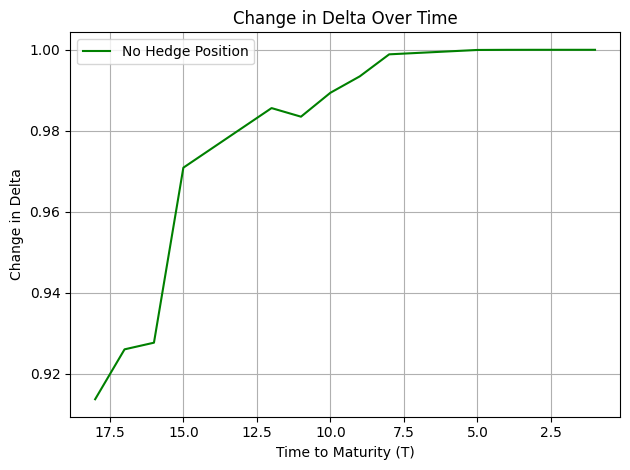

In [675]:
import matplotlib.pyplot as plt

# Sort by T in ascending order first (just in case)
Options_Call = Options_Call.sort_values(by="T", ascending=True)

# Plot
plt.plot(Options_Call["T"], Options_Call['Calculated_Delta'], label="No Hedge Position", color="g")
plt.xlabel("Time to Maturity (T)")
plt.ylabel("Change in Delta")
plt.title("Change in Delta Over Time")
plt.grid(True)

# Reverse the x-axis (so T goes from 25 to 0)
plt.gca().invert_xaxis()

plt.legend()  # Ensure the legend is displayed
plt.tight_layout()
plt.show()


